In [1]:
import numpy as np
import pandas as pd
import torch
import random
import sys
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
#pip install hydroeval
import hydroeval as he
#pip install -U seaborn
import copy
from os import listdir
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

torch.manual_seed(22)
sns.set_style("white")
sns.set_context("talk", font_scale = 1)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
forcings_d = {'DryCreek': ['TL_Precipitation', 'TL_Evapotranspiration', 'TL_AirTemperature'],
                      'HJAndrews': ['PRIMET_Precipitation', 'PRIMET_Evapotranspiration', 'PRIMET_AirTemperature'],
                      'HarvardForest': ['HF001_Precipitation','HF001_Evapotranspiration', 'HF001_AirTemperature'],
                      'HubbardBrook': ['WS7_Precipitation', 'STAHQ_Evapotranspiration','STAHQ_AirTemperature'],
                      'JornadaBasin': ['JWSTA_Precipitation','JWSTA_Evapotranspiration','JWSTA_AirTemperature'],
                      'Kellogg': ['KBS002_Precipitation',  'KBS002_Evapotranspiration', 'KBS002_AirTemperature'],
                      'KonzaPrairie': ['HQ01_Precipitation', 'HQ01_Evapotranspiration','HQ01_AirTemperature'],
                      'Sevilleta': ['Station44_Precipitation', 'Station44_Evapotranspiration','Station44_AirTemperature']}

discharge_d = { 'DryCreek': ['LG_Discharge'],
                        'HJAndrews': ['GSLOOK_Discharge'],
                        'HarvardForest': ['BigelowLower_Discharge'],
                        'HubbardBrook': ['WS7_Discharge'],
                        'JornadaBasin': ['SaltCreek_Discharge'],
                        'Kellogg': ['KBS096_Discharge'],
                        'KonzaPrairie':['KingsCreek_Discharge'],
                        'Sevilleta':['Bernado_Discharge']}

In [7]:
base_dir = os.getcwd().rsplit('/',1)[0]

In [3]:
def normalize(data):
    data = data-np.min(data)
    data = data/np.max(data)
    return data

#def normalize2(data):
    #data = data-np.min(data)
 #   data = data/np.max(data)
  #  return data

In [4]:
def convert_to_letter(number):
    if 0 <= number < 26:
        return chr(ord('A') + number)
    else:
        return "Invalid input"

# Examples
print(convert_to_letter(0))  # Output: A
print(convert_to_letter(1))  # Output: B
print(convert_to_letter(2))  # Output: C
# ...
print(convert_to_letter(25))  # Output: Z


A
B
C
Z


In [5]:
def spline(y):
    x = range(0, len(y))
    spl = splrep(x, y)
    spl = interpolate.splrep(x, y, s=2)
    yfit = splev(x, spl)
    return yfit


def plot_concept(ws, df, method='spline'):
    # splie resource: https://www.datatechnotes.com/2021/11/scattered-data-spline-fitting-example.html
    sns.set_style("white")
    sns.set_context("talk", font_scale = 1.2)

    if method=='spline':
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html
    # https://www.datatechnotes.com/2021/11/scattered-data-spline-fitting-example.html
        plt.plot(df['lambda'].values, spline(df['NSE_norm'].values), '-', c="orange")
        plt.plot(df['lambda'].values, df['NSE_norm'].values, '.', c="orange", label="accuracy")
        
        plt.plot(df['lambda'].values, spline(df['stability_norm'].values), '-', c="g")
        plt.plot(df['lambda'].values, df['stability_norm'].values, '.', c="g", label="stability")

        plt.plot(df['lambda'].values, spline(df['phys_const_norm'].values), '-', c="royalblue")
        plt.plot(df['lambda'].values, df['phys_const_norm'].values, '.', c="royalblue", label="physical consistency")

    elif method == 'cubic':
        sns.regplot(x="lambda", y="phys_const_norm", data=df,
                   order=3, ci=None, scatter_kws={"s": 10},label='physical consistency') 

        sns.regplot(x="lambda", y="NSE_norm", data=df,
                   order=3, ci=None, scatter_kws={"s": 10},label='model accuracy')  

        sns.regplot(x="lambda", y="stability_norm", data=df,
                   order=3, ci=None, scatter_kws={"s": 10},label='stability')  
    
    elif method == 'trf':
        def curve_model(x, a, b, c):
            return a * x**2 + b * x + c
        params, covariance = curve_fit(curve_model, df['lambda'].values, df['NSE_norm'].values, method='trf')
        fitted_curve_NSE = curve_model(df['lambda'].values, *params)
        
        params, covariance = curve_fit(curve_model, df['lambda'].values, df['stability_norm'].values, method='trf')
        fitted_curve_stability = curve_model(df['lambda'].values, *params)
        
        params, covariance = curve_fit(curve_model, df['lambda'].values, df['phys_const_norm'].values, method='trf')
        fitted_curve_phy = curve_model(df['lambda'].values, *params)
        
        plt.plot(df['lambda'].values, fitted_curve_NSE, '-', c="orange")
        plt.plot(df['lambda'].values, df['NSE_norm'].values, '.', c="orange", label="accuracy")
        
        plt.plot(df['lambda'].values, fitted_curve_stability, '-', c="g")
        plt.plot(df['lambda'].values, df['stability_norm'].values, '.', c="g", label="stability")

        plt.plot(df['lambda'].values, fitted_curve_phy, '-', c="royalblue")
        plt.plot(df['lambda'].values, df['phys_const_norm'].values, '.', c="royalblue", label="physical consistency")
    

In [6]:
def get_watershed_df(watershed,
                     scenario = 'changing_lambda',
                     exp = 'PILSTM_PPT_ET_1out',
                     dir_path = f'{base_dir}/neuralhydrology-pilstm/experiments'):
    
    watershed_lower = watershed.lower()
    watershed_df = pd.DataFrame()
        
    NSE_df = pd.read_csv(f"{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv",
                            index_col = 0)
    #watershed_df = NSE_df[NSE_df['basin'] == watershed][['lambda', 'Qpilstm(mm/d)_NSE','wb_deficit_avg']]
    watershed_df = NSE_df[NSE_df['basin'] == watershed][['lambda', 'NSE','wb_deficit_avg']]
             
    watershed_df.columns = ['lambda', 'NSE','wb_deficit_avg']
    #display(watershed_df.head())
        
    watershed_df_ensemble = watershed_df.groupby('lambda').mean()
    watershed_df_ensemble['NSE_std'] = watershed_df.groupby('lambda').std()['NSE']
        
    # normalize everything
    watershed_df_ensemble['NSE_norm'] = normalize(watershed_df_ensemble['NSE'])
    watershed_df_ensemble['phys_const_norm'] = 1-normalize(watershed_df_ensemble['wb_deficit_avg'])
    watershed_df_ensemble['stability_norm'] = 1-normalize(watershed_df_ensemble['NSE_std'])
    
    watershed_df_ensemble = watershed_df_ensemble.reset_index()
    
    return watershed_df_ensemble

PILSTM_PPT_ET_1out
DryCreek


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.638418        0.066846  0.151869  0.113484         0.399556   
1    0.02  0.607298        0.073173  0.154269  0.000000         0.000000   
2    0.04  0.646233        0.066028  0.157118  0.141984         0.451198   
3    0.06  0.648511        0.067090  0.158351  0.150291         0.384172   
4    0.08  0.702556        0.062008  0.129533  0.347375         0.705066   

   stability_norm  
0        0.041822  
1        0.026336  
2        0.007956  
3        0.000000  
4        0.185922

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.638418        0.066846  0.151869  0.113484         0.399556   

   stability_norm  
0        0.041822

HJAndrews


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.619403        0.102808  0.027514  0.000000         0.163017   
1    0.02  0.639915        0.102018  0.020526  0.074944         0.177417   
2    0.04  0.651106        0.105826  0.020935  0.115832         0.107943   
3    0.06  0.663149        0.106230  0.021362  0.159835         0.100577   
4    0.08  0.676910        0.107915  0.022819  0.210112         0.069829   

   stability_norm  
0        0.240621  
1        0.462772  
2        0.449771  
3        0.436175  
4        0.389865

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.619403        0.102808  0.027514       0.0         0.163017   

   stability_norm  
0        0.240621

HarvardForest


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.712147        0.118028  0.002421  0.000000         0.000000   
1    0.02  0.714513        0.117897  0.002588  0.015010         0.005807   
2    0.04  0.716492        0.117599  0.002684  0.027561         0.019046   
3    0.06  0.718434        0.116986  0.003362  0.039880         0.046297   
4    0.08  0.721041        0.116556  0.003536  0.056418         0.065396   

   stability_norm  
0        0.999026  
1        0.995660  
2        0.993716  
3        0.980031  
4        0.976513

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.712147        0.118028  0.002421       0.0              0.0   

   stability_norm  
0        0.999026

HubbardBrook


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.462344        0.265586  0.008911  0.000000         0.000000   
1    0.02  0.468708        0.264430  0.008960  0.015510         0.004944   
2    0.04  0.474352        0.261416  0.007555  0.029263         0.017828   
3    0.06  0.479337        0.259781  0.006453  0.041413         0.024817   
4    0.08  0.485399        0.256588  0.005056  0.056187         0.038465   

   stability_norm  
0        0.024164  
1        0.017562  
2        0.207371  
3        0.356375  
4        0.545094

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.462344        0.265586  0.008911       0.0              0.0   

   stability_norm  
0        0.024164

JornadaBasin


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00 -3.503475        1.218848  0.363123  1.000000         1.000000   
1    0.02 -3.630770        1.224573  0.376104  0.990372         0.980684   
2    0.04 -3.764800        1.230334  0.389738  0.980236         0.961244   
3    0.06 -3.920149        1.248497  0.415476  0.968486         0.899959   
4    0.08 -4.068209        1.252949  0.430418  0.957288         0.884936   

   stability_norm  
0        1.000000  
1        0.990908  
2        0.981358  
3        0.963331  
4        0.952865

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0 -3.503475        1.218848  0.363123       1.0              1.0   

   stability_norm  
0             1.0

Kellogg


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.672932        0.139103  0.015332  0.925287         0.000000   
1    0.02  0.676460        0.138232  0.016411  0.941142         0.078656   
2    0.04  0.678137        0.137465  0.016679  0.948676         0.147879   
3    0.06  0.679627        0.136720  0.016943  0.955375         0.215178   
4    0.08  0.680980        0.135943  0.017278  0.961457         0.285327   

   stability_norm  
0        0.894016  
1        0.861311  
2        0.853181  
3        0.845171  
4        0.835021

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.672932        0.139103  0.015332  0.925287              0.0   

   stability_norm  
0        0.894016

KonzaPrairie


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.554032        0.547322  0.011434  1.000000         0.225120   
1    0.02  0.552735        0.530184  0.015266  0.999796         0.410423   
2    0.04  0.552867        0.518016  0.017247  0.999817         0.541984   
3    0.06  0.552296        0.506053  0.019388  0.999727         0.671331   
4    0.08  0.550726        0.495313  0.021824  0.999480         0.787459   

   stability_norm  
0        0.981110  
1        0.969318  
2        0.963221  
3        0.956631  
4        0.949131

lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.554032        0.547322  0.011434       1.0          0.22512   

   stability_norm  
0         0.98111

Sevilleta


lambda       NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0    0.00  0.037230        0.230260  0.018344  0.003781         1.000000   
1    0.02  0.036854        0.231810  0.018481  0.000000         0.904711   
2    0.04  0.037628        0.231609  0.019124  0.007789         0.917051   
3    0.06  0.039249        0.234973  0.020485  0.024086         0.710266   
4    0.08  0.048446        0.240653  0.013490  0.116586         0.361050   

   stability_norm  
0        0.706475  
1        0.701899  
2        0.680481  
3        0.635166  
4        0.868167

lambda      NSE  wb_deficit_avg   NSE_std  NSE_norm  phys_const_norm  \
0     0.0  0.03723         0.23026  0.018344  0.003781              1.0   

   stability_norm  
0        0.706475

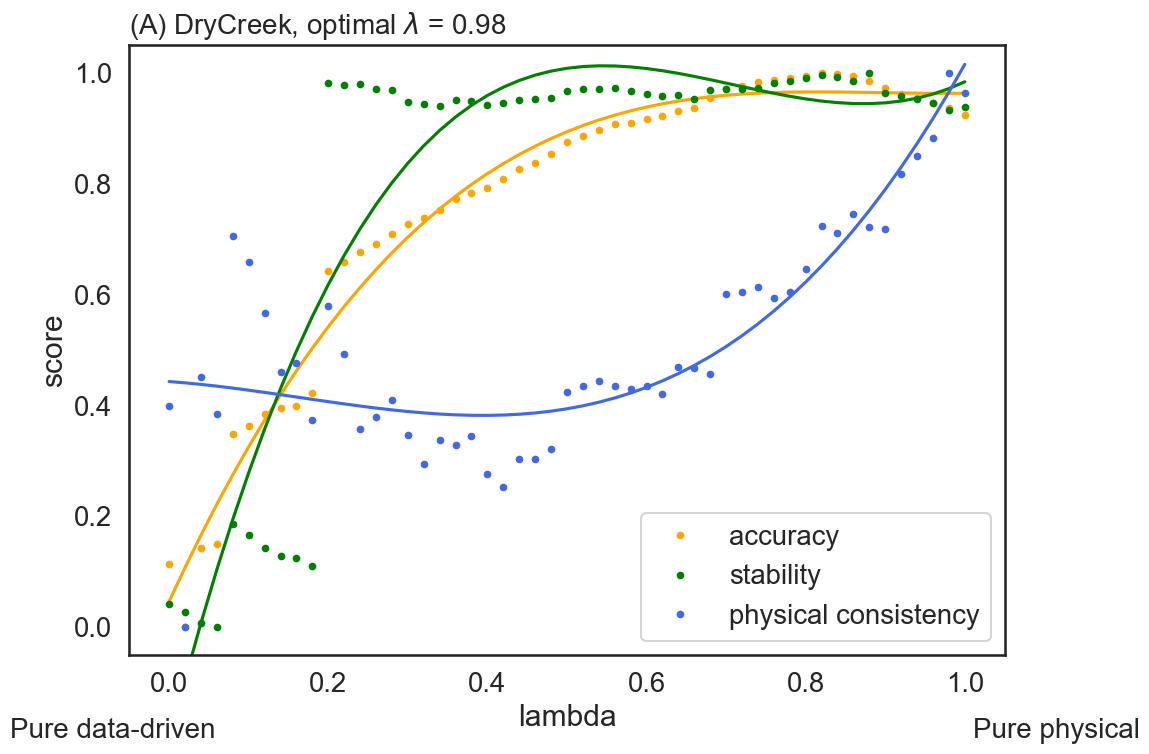

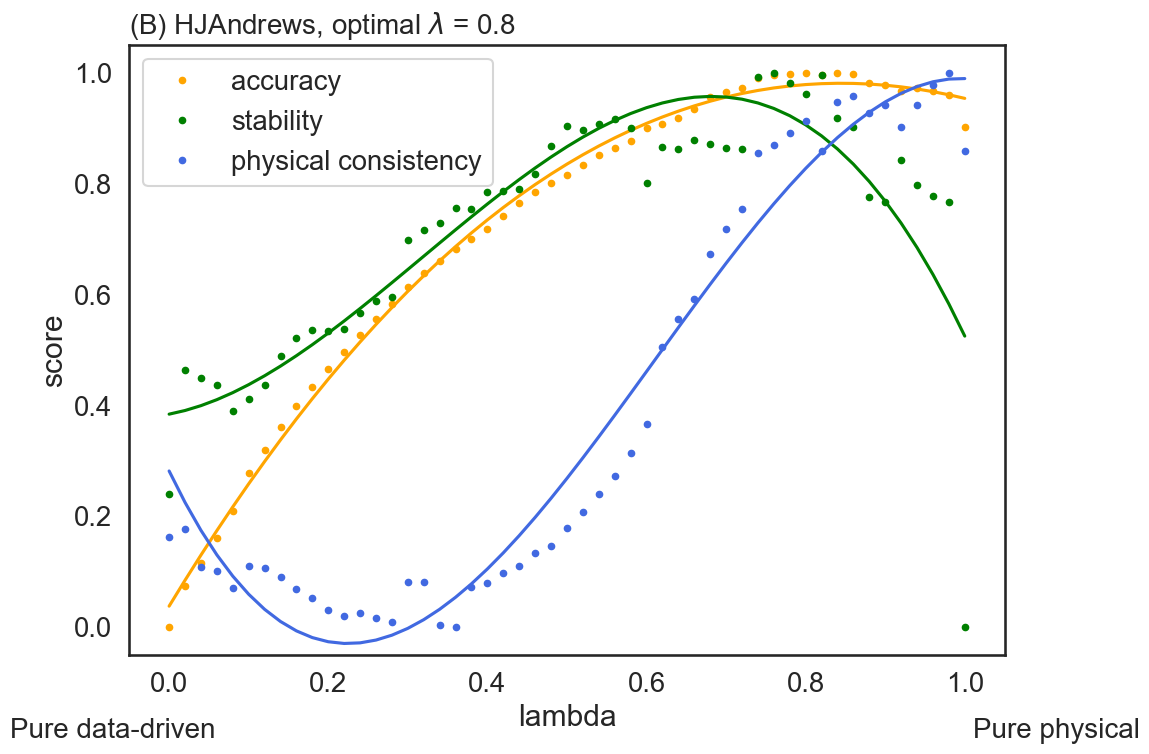

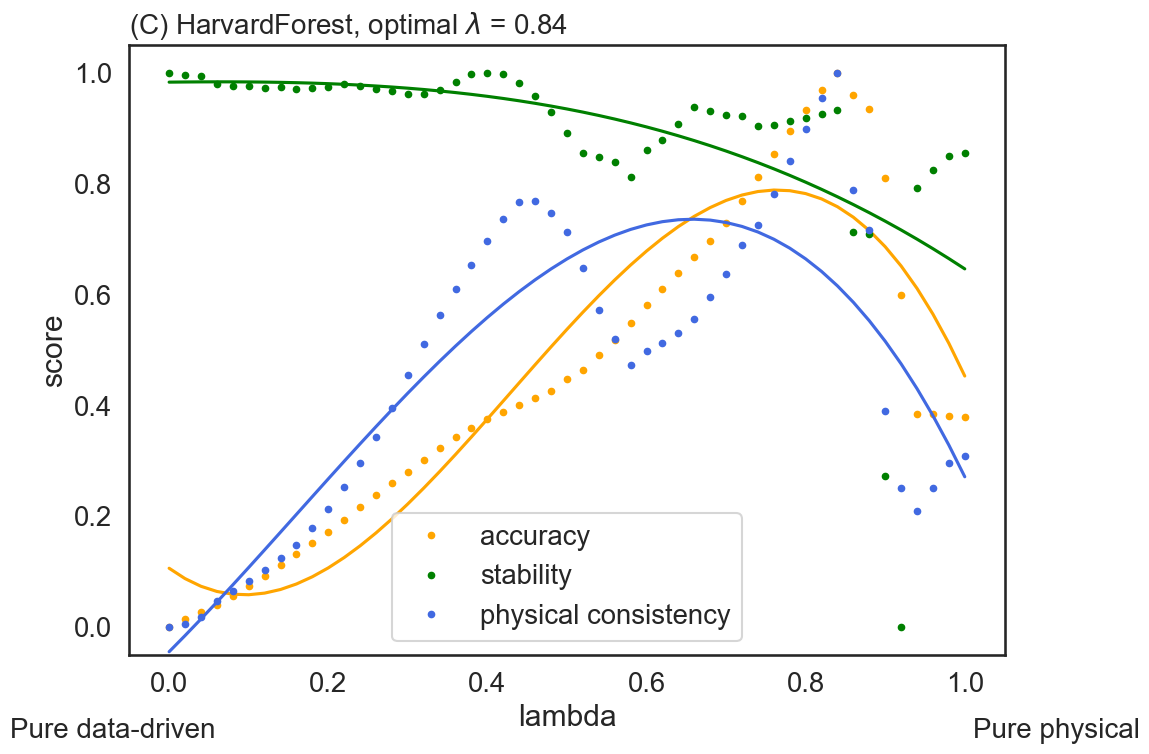

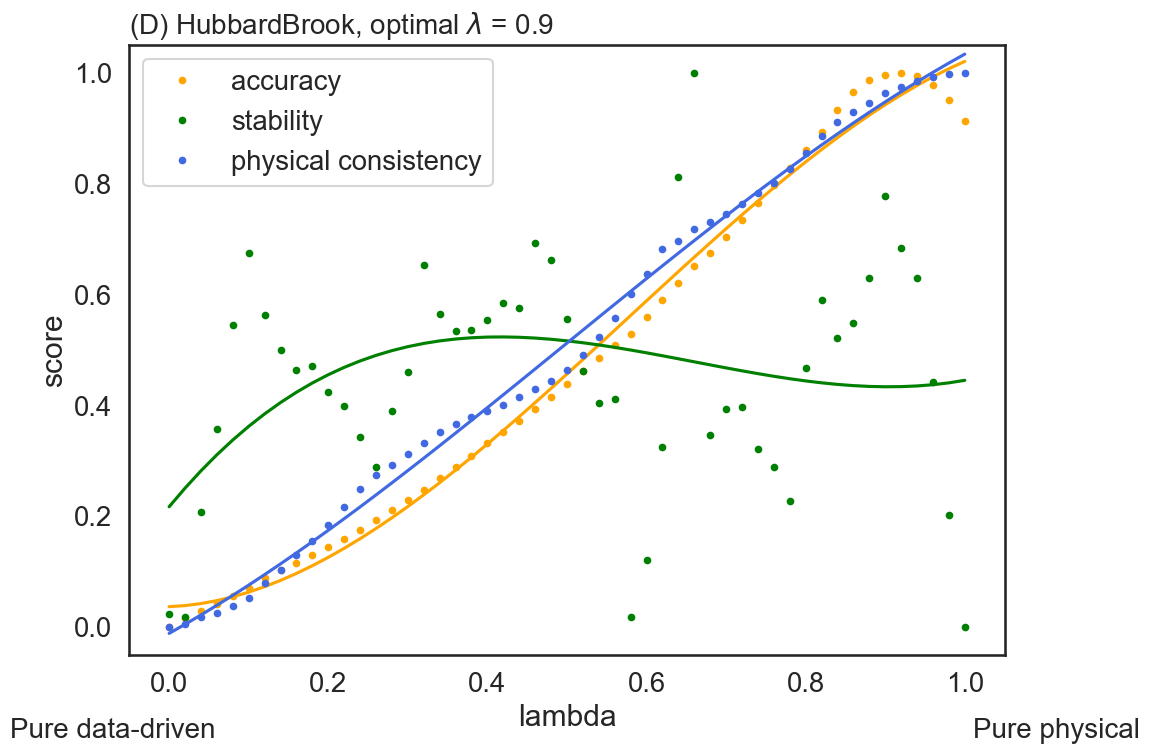

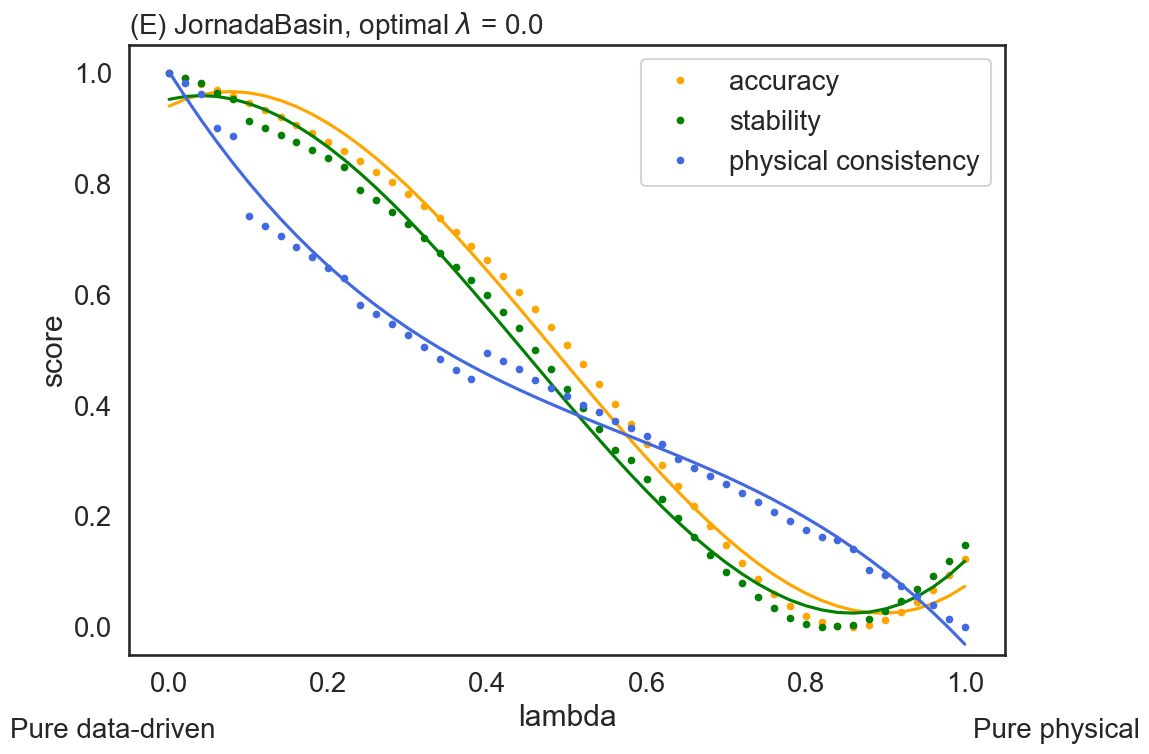

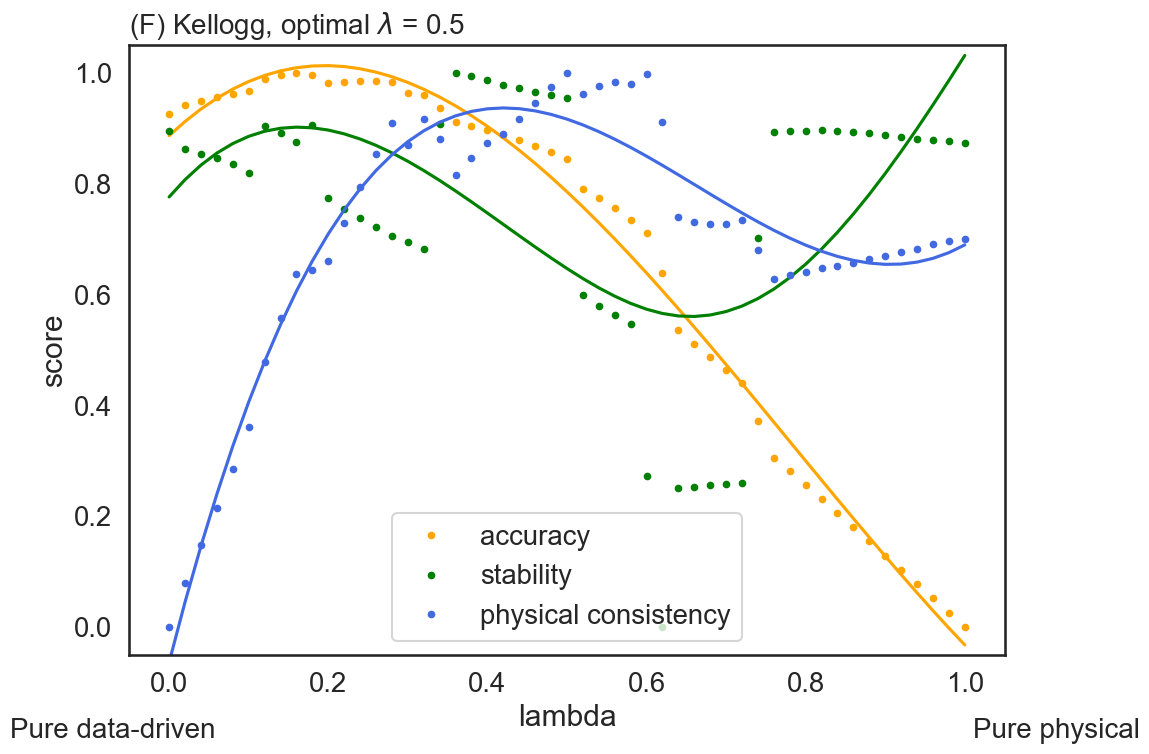

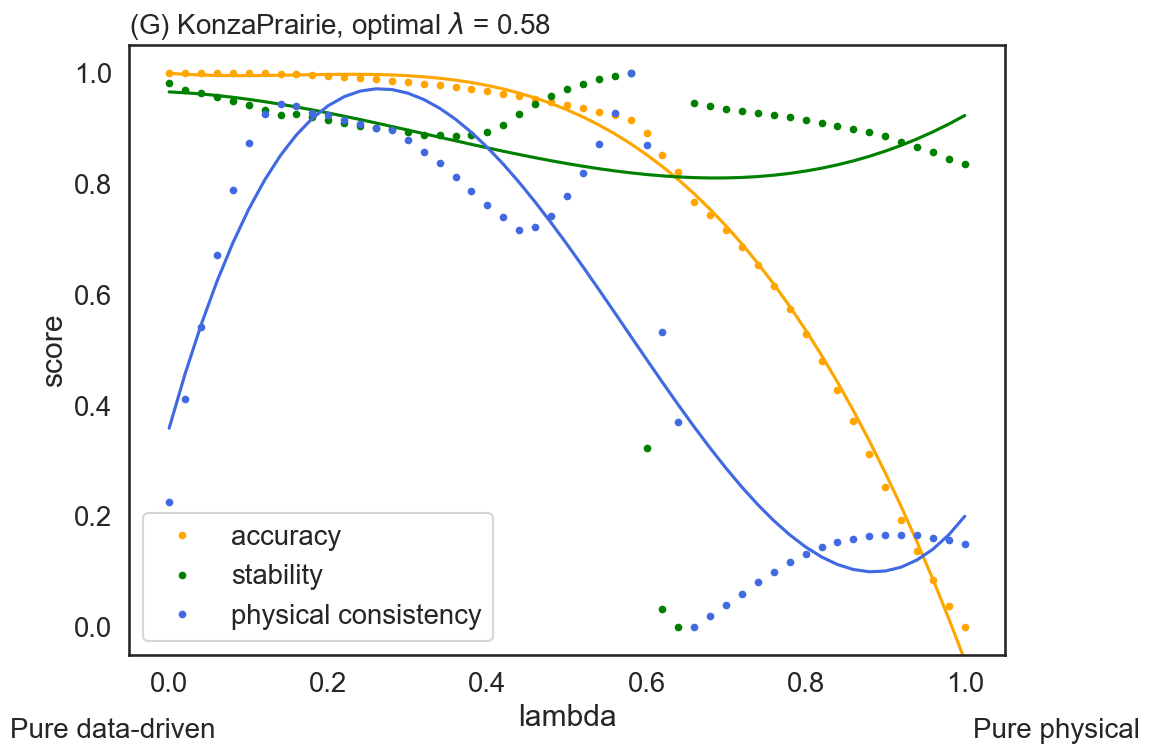

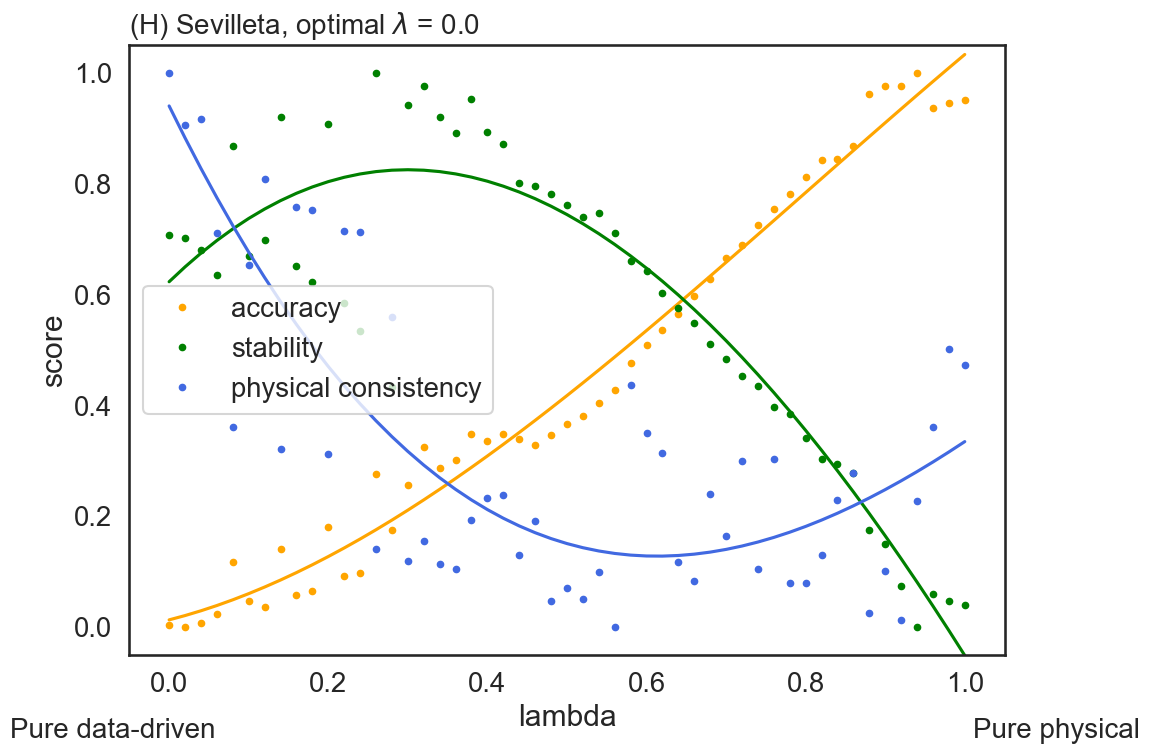

In [19]:
watersheds = ['DryCreek','HJAndrews','HarvardForest','HubbardBrook',
              'JornadaBasin','Kellogg','KonzaPrairie','Sevilleta']

dir_path = f'{base_dir}/neuralhydrology-pilstm/experiments'
data_path = f'{base_dir}/chosen_data/'
scenario = 'changing_lambda'

for exp in ['PILSTM_PPT_ET_1out']:
    print(exp)
    exp_lower = exp.lower()
    
    for i,watershed in enumerate(watersheds):
        print(watershed)
        watershed_lower = watershed.lower()
        watershed_df = pd.DataFrame()
        
        NSE_df = pd.read_csv(f"{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv",
                            index_col = 0)
        watershed_df = NSE_df[NSE_df['basin'] == watershed][['lambda', 'Qpilstm(mm/d)_NSE','wb_deficit_avg']]
        
        watershed_df.columns = ['lambda', 'NSE','wb_deficit_avg']
        #display(watershed_df.head())
        
        watershed_df_ensemble = watershed_df.groupby('lambda').mean()
        watershed_df_ensemble['NSE_std'] = watershed_df.groupby('lambda').std()['NSE']
        
        # normalize everything
        watershed_df_ensemble['NSE_norm'] = normalize(watershed_df_ensemble['NSE'])
        watershed_df_ensemble['phys_const_norm'] = 1-normalize(watershed_df_ensemble['wb_deficit_avg'])
        watershed_df_ensemble['stability_norm'] = 1-normalize(watershed_df_ensemble['NSE_std'])
        
        
        watershed_df_ensemble = watershed_df_ensemble.reset_index()
        display(watershed_df_ensemble.head())
       # watershed_df_ensemble = watershed_df_ensemble.loc[np.arange(0,101,2),:] #######
        
        # add generalization ability
        #gen_df = pd.read_csv(f"{dir_path}/{exp}/results/climatechange_lambda/{exp}_ensemble_eval_result_{watershed_lower}.csv",
         #                   index_col = 0)
            
        display(watershed_df_ensemble.head(1))
        
        # get the best lambda value
        #total_score = spline(watershed_df_ensemble['phys_const_norm'].values)+spline(watershed_df_ensemble['NSE_norm'].values)+spline(watershed_df_ensemble['stability_norm'].values)
        total_score = watershed_df_ensemble[['phys_const_norm','NSE_norm','stability_norm']].sum(axis=1)
        
        #print(df['lambda'].values[np.argmax(total_score)])
        optimal_lambda = watershed_df_ensemble['lambda'].values[np.argmax(total_score)]
        
        ################ plot figure
        plt.figure(figsize=(12,8))
        plot_concept(watershed, watershed_df_ensemble, method='spline')
        
        plt.xlabel('lambda')
        plt.ylabel('score')
        
        plt.text(-0.2, -0.2, 'Pure data-driven', fontsize=20 )
        plt.text(1.01, -0.2, 'Pure physical', fontsize=20 )
        
        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05,1.05)
        
        letter = convert_to_letter(i)
        title = f'({letter}) {watershed}, optimal '+ r'$\lambda$' +f' = {round(optimal_lambda,2)}'
        
        plt.text(-0.05, 1.07, title, fontsize=20)
        plt.legend()
        
        plt.tight_layout()
        #plt.savefig(f'figures/conceptual/Figure 8.{watershed}_conceptual_figure.png', dpi=200)
       

DryCreek
HJAndrews
HarvardForest
HubbardBrook
JornadaBasin
Kellogg
KonzaPrairie
Sevilleta


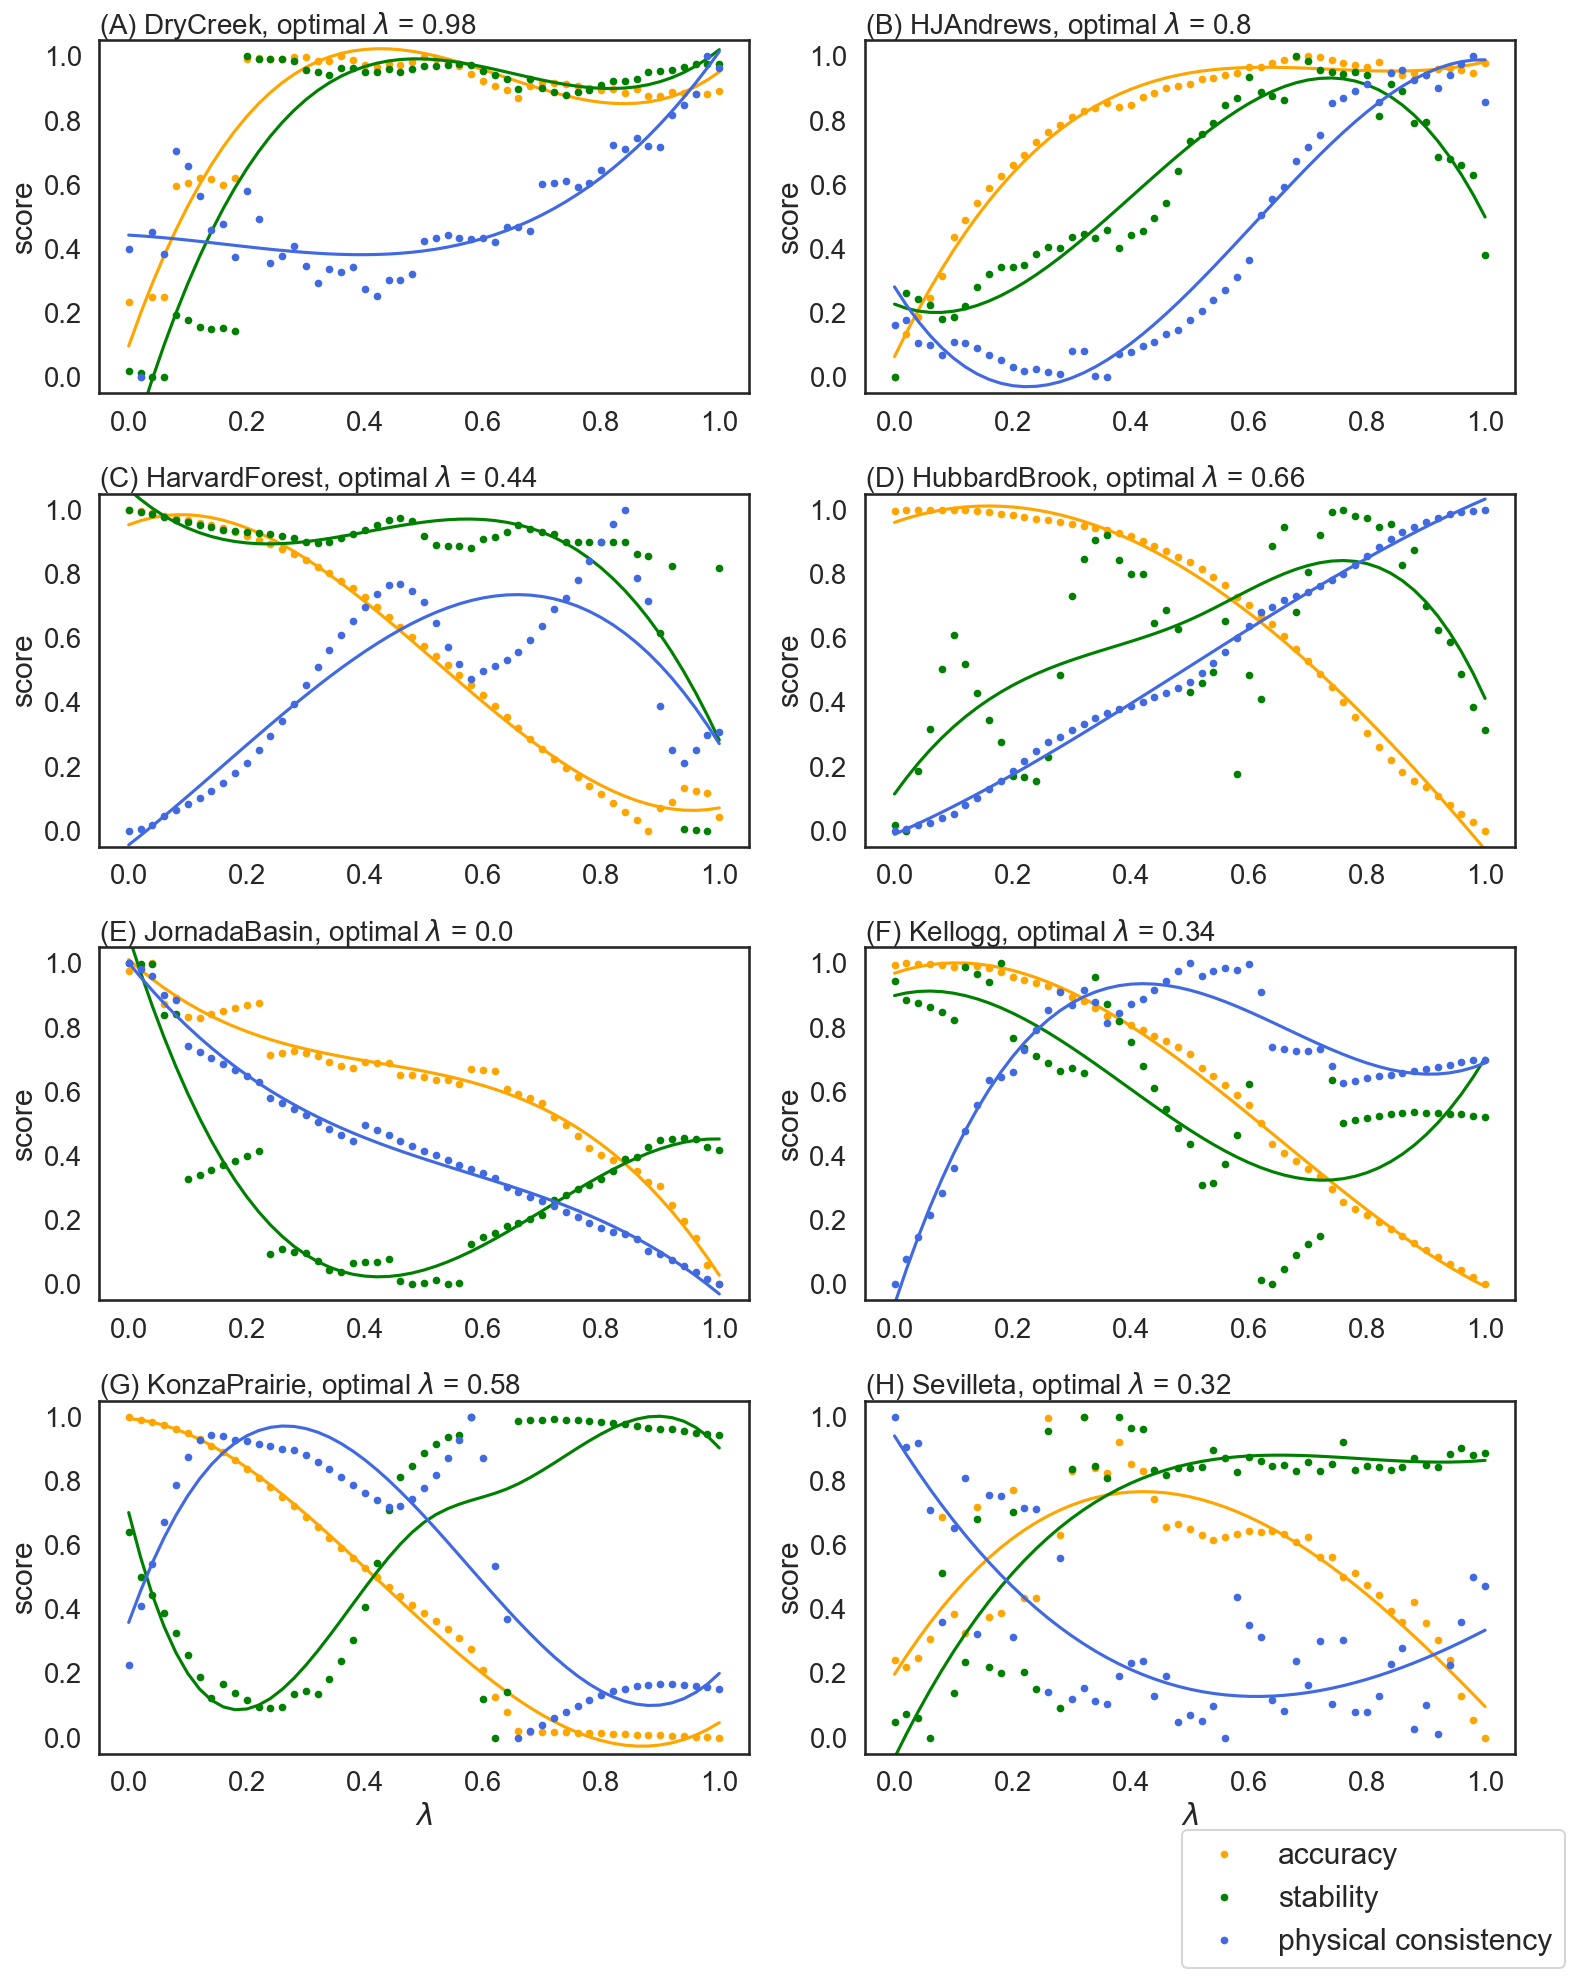

In [20]:
watersheds = ['DryCreek','HJAndrews','HarvardForest','HubbardBrook',
              'JornadaBasin','Kellogg','KonzaPrairie','Sevilleta']
dir_path = f'{base_dir}/neuralhydrology-pilstm/experiments'
data_path = f'{base_dir}/chosen_data/'

exp = 'PILSTM_PPT_ET_1out'
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
sns.set_style("white")
sns.set_context("talk", font_scale = 1)

for i,watershed in enumerate(watersheds):
    watershed_df_ensemble = get_watershed_df(watershed, exp = exp)
    #watershed_df_ensemble = watershed_df_ensemble.loc[np.arange(0,101,2),:] #######
    print(watershed)
    
    #display(watershed_df_ensemble.head(1))
        
    total_score = watershed_df_ensemble[['phys_const_norm','NSE_norm','stability_norm']].sum(axis=1)
    optimal_lambda = watershed_df_ensemble['lambda'].values[np.argmax(total_score)]
        
        
    ################ plot figure
    # Plot on each subplot
    df = watershed_df_ensemble
    
    ax = axes[i//2, i%2]
    
    ax.plot(df['lambda'].values, spline(df['NSE_norm'].values), '-', c="orange")
    ax.plot(df['lambda'].values, df['NSE_norm'].values, '.', c="orange", label="accuracy")
        
    ax.plot(df['lambda'].values, spline(df['stability_norm'].values), '-', c="g")
    ax.plot(df['lambda'].values, df['stability_norm'].values, '.', c="g", label="stability")

    ax.plot(df['lambda'].values, spline(df['phys_const_norm'].values), '-', c="royalblue")
    ax.plot(df['lambda'].values, df['phys_const_norm'].values, '.', c="royalblue", label="physical consistency")

    ax.set_xlabel('')
    ax.set_ylabel('score')
        
    #ax.text(-0.2, -0.2, 'Pure data-driven', fontsize=20 )
    #ax.text(1.01, -0.2, 'Pure physical', fontsize=20 )
        
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)
        
    letter = convert_to_letter(i)
    title = f'({letter}) {watershed}, optimal '+ r'$\lambda$' +f' = {round(optimal_lambda,2)}'
        
    ax.text(-0.05, 1.07, title, fontsize=20)

axes[3,1].set_xlabel(r'$\lambda$')
axes[3,0].set_xlabel(r'$\lambda$')
axes[3,1].legend(loc='lower right', bbox_to_anchor=(1.1, -0.65),fontsize='large')
        
plt.tight_layout()
plt.savefig(f'figures/Figure 7.conceptual_figure_new.png', dpi=200)
       